Key Path: Channel 0
Total Time: 87 cycles
Total Stall Time: 12 cycles
   task_id task_name  channel_id  start_cycle  end_cycle  stall_cycle  \
0        1    Task A           0            0         10            0   
1        2    Task B           0           10         25            0   
2        3    Task C           1           10         22           10   
3        4    Task D           1           22         37            0   
4        5    Task E           0           37         57           12   
5        6    Task F           1           57         72           20   
6        7    Task G           0           57         77            0   
7        8    Task H           0           77         87            0   

  blocked_channels  
0              [1]  
1               []  
2               []  
3              [0]  
4              [1]  
5               []  
6               []  
7               []  


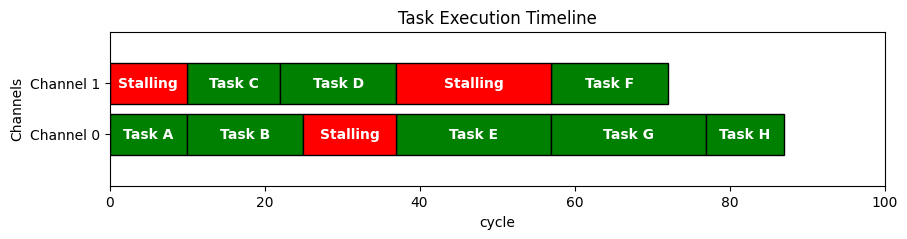

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

class TaskProfile:
    def __init__(self, task_id, task_name, channel_id, latency, blocking, blocked_channels):
        self.task_id = task_id
        self.task_name = task_name  # 任务名称
        self.channel_id = channel_id  # 任务所属的channel
        self.blocking = blocking
        self.latency = latency
        self.start_cycle = 0
        self.end_cycle = 0
        self.stall_cycle = 0
        self.blocked_channels = blocked_channels  # 指定哪些channels会被block

    @staticmethod
    def simulate_pipeline(tasks):
        # 存储每个channel的当前结束时间和stall时间
        channel_end_cycles = {}
        channel_stall_times = {}

        results = []

        for task in tasks:
            # 获取当前channel的最早可开始时间
            channel_id = task.channel_id
            if channel_id in channel_end_cycles:
                start_cycle = channel_end_cycles[channel_id]
            else:
                start_cycle = 0

            # 检查是否有其他任务阻塞了该任务所在的channel
            for other_task in tasks:
                if task.channel_id in other_task.blocked_channels:
                    if other_task.end_cycle > start_cycle:
                        task.stall_cycle += other_task.end_cycle - start_cycle
                        start_cycle = other_task.end_cycle

            # 如果当前任务是阻塞任务，更新它阻塞的channel的结束时间
            if task.blocking:
                for blocked_channel in task.blocked_channels:
                    if blocked_channel in channel_end_cycles:
                        if channel_end_cycles[blocked_channel] < task.end_cycle:
                            channel_end_cycles[blocked_channel] = task.end_cycle

            # 计算任务的开始时间和结束时间
            task.start_cycle = start_cycle
            task.end_cycle = task.start_cycle + task.latency

            # 更新该channel的结束时间
            channel_end_cycles[channel_id] = task.end_cycle

            # 累加该channel的stall时间
            if channel_id not in channel_stall_times:
                channel_stall_times[channel_id] = 0
            channel_stall_times[channel_id] += task.stall_cycle
            # print(f"channel_id {channel_id} task.stall_cycle {task.stall_cycle} {channel_stall_times[channel_id]}")

            # 将任务信息记录下来
            results.append({
                'task_id': task.task_id,
                'task_name': task.task_name,  # 记录task_name
                'channel_id': task.channel_id,  # 记录channel_id
                'start_cycle': task.start_cycle,
                'end_cycle': task.end_cycle,
                'stall_cycle': task.stall_cycle,
                'blocked_channels': task.blocked_channels  # 被阻塞的channels
            })

        # 找出最后完成的channel
        final_channel = max(channel_end_cycles, key=channel_end_cycles.get)
        final_end_cycle = channel_end_cycles[final_channel]
        final_stall_time = channel_stall_times[final_channel]

        print(f"Key Path: Channel {final_channel}")
        print(f"Total Time: {final_end_cycle} cycles")
        print(f"Total Stall Time: {final_stall_time} cycles")

        return results

    @staticmethod
    def visualize_pipeline(tasks):
        # 按channel_id进行分组和排序
        tasks_sorted = sorted(tasks, key=lambda x: x.channel_id)

        fig, ax = plt.subplots(figsize=(10, 2))

        # 设置xy轴的范围
        ax.set_ylim(-1, 2)
        ax.set_xlim(0, 100)

        # 记录绘制的Y轴对应的channel
        channel_positions = {}
        current_channel_position = 0

        for task in tasks_sorted:
            # 如果是新的channel，更新绘图的位置
            if task.channel_id not in channel_positions:
                channel_positions[task.channel_id] = current_channel_position
                current_channel_position += 1

            # 任务的起始时间和长度
            start_cycle = task.start_cycle
            duration = task.latency
            channel_y_position = channel_positions[task.channel_id]

            # 可视化任务的执行区间，设置边框颜色和宽度
            ax.barh(channel_y_position, duration, 
                    left=start_cycle, color='green', edgecolor='black', linewidth=1)

            # 在条形图中间添加任务名称
            ax.text(start_cycle + duration / 2, channel_y_position, task.task_name, 
                    va='center', ha='center', color='white', fontweight='bold')

            # 如果存在等待时间，绘制等待时间的部分，设置边框颜色和宽度
            if task.stall_cycle > 0:
                ax.barh(channel_y_position, task.stall_cycle, 
                        left=start_cycle - task.stall_cycle, color='red', edgecolor='black', linewidth=1)

                # 在等待的红色部分添加文本
                ax.text(start_cycle - task.stall_cycle / 2, channel_y_position, 'Stalling',
                        va='center', ha='center', color='white', fontweight='bold')

        # 设置Y轴标签为对应的channel
        ax.set_yticks(list(channel_positions.values()))
        ax.set_yticklabels([f'Channel {channel_id}' for channel_id in channel_positions.keys()])

        ax.set_xlabel('cycle')
        ax.set_ylabel('Channels')
        ax.set_title('Task Execution Timeline')

        plt.show()

if __name__ == "__main__":
    tasks = [
        TaskProfile(1, "Task A", channel_id=0, latency=10, blocking=True, blocked_channels=[1]),
        TaskProfile(2, "Task B", channel_id=0, latency=15, blocking=False, blocked_channels=[]),
        TaskProfile(3, "Task C", channel_id=1, latency=12, blocking=False, blocked_channels=[]),
        TaskProfile(4, "Task D", channel_id=1, latency=15, blocking=True, blocked_channels=[0]),
        TaskProfile(5, "Task E", channel_id=0, latency=20, blocking=True, blocked_channels=[1]),
        TaskProfile(6, "Task F", channel_id=1, latency=15, blocking=False, blocked_channels=[]),
        TaskProfile(7, "Task G", channel_id=0, latency=20, blocking=False, blocked_channels=[]),
        TaskProfile(8, "Task H", channel_id=0, latency=10, blocking=False, blocked_channels=[])
    ]

    results = TaskProfile.simulate_pipeline(tasks)
    df = pd.DataFrame(results)
    print(df)

    # 可视化任务的执行流水线
    TaskProfile.visualize_pipeline(tasks)


start_cycle=0
stall_cycle=0
start_cycle=10
stall_cycle=0
start_cycle=10
stall_cycle=0
start_cycle=22
stall_cycle=0
start_cycle=37
stall_cycle=0
start_cycle=37
stall_cycle=0
start_cycle=57
stall_cycle=0
start_cycle=77
stall_cycle=0
Key Path: Channel 0
Total Time: 87 cycles
Stall Time: 0 cycles
   task_id task_name  channel_id  start_cycle  end_cycle  stall_cycle  \
0        1    Task A           0            0         10            0   
1        2    Task B           0           10         25            0   
2        3    Task C           1           10         22            0   
3        4    Task D           1           22         37            0   
4        5    Task E           0           37         57            0   
5        6    Task F           1           37         52            0   
6        7    Task G           0           57         77            0   
7        8    Task H           0           77         87            0   

  blocked_channels  
0              [1]  
1     

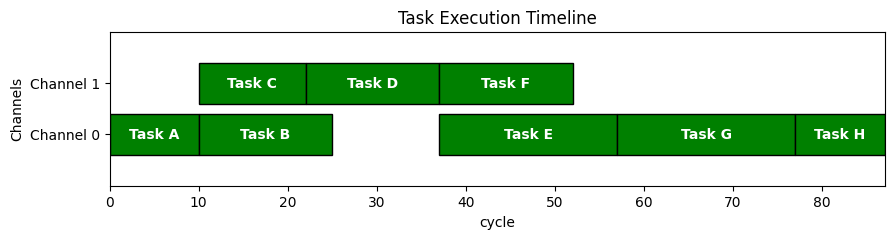

In [13]:
# import pandas as pd
# import matplotlib.pyplot as plt

# class TaskProfile:
#     def __init__(self, task_id, task_name, channel_id, latency, blocking, blocked_channels):
#         self.task_id = task_id
#         self.task_name = task_name
#         self.channel_id = channel_id
#         self.blocking = blocking
#         self.latency = latency
#         self.start_cycle = 0
#         self.end_cycle = 0
#         self.stall_cycle = 0
#         self.blocked_channels = blocked_channels

#     @staticmethod
#     def simulate_pipeline(tasks):
#         channel_end_cycles = {}
#         channel_stall_times = {}
#         results = []

#         for task in tasks:
#             start_cycle = channel_end_cycles.get(task.channel_id, 0)
#             print(f"start_cycle={start_cycle}")
#             task.stall_cycle = TaskProfile._calculate_stall_time(task, tasks, start_cycle)
#             print(f"stall_cycle={task.stall_cycle}")
#             task.start_cycle = start_cycle + task.stall_cycle
#             task.end_cycle = task.start_cycle + task.latency

#             TaskProfile._update_channel_times(task, channel_end_cycles, channel_stall_times)
#             results.append(TaskProfile._create_task_result(task))

#         TaskProfile._print_final_stats(channel_end_cycles, channel_stall_times)
#         return results

#     @staticmethod
#     def _calculate_stall_time(task, tasks, start_cycle):
#         stall_time = 0
#         for other_task in tasks:
#             if other_task.blocking and task.channel_id in other_task.blocked_channels:
#                 if other_task.end_cycle > start_cycle:
#                     stall_time = max(stall_time, other_task.end_cycle - start_cycle)
#         return stall_time

#     @staticmethod
#     def _update_channel_times(task, channel_end_cycles, channel_stall_times):
#         channel_end_cycles[task.channel_id] = task.end_cycle
#         if task.blocking:
#             for blocked_channel in task.blocked_channels:
#                 channel_end_cycles[blocked_channel] = max(channel_end_cycles.get(blocked_channel, 0), task.end_cycle)
#         channel_stall_times[task.channel_id] = channel_stall_times.get(task.channel_id, 0) + task.stall_cycle

#     @staticmethod
#     def _create_task_result(task):
#         return {
#             'task_id': task.task_id,
#             'task_name': task.task_name,
#             'channel_id': task.channel_id,
#             'start_cycle': task.start_cycle,
#             'end_cycle': task.end_cycle,
#             'stall_cycle': task.stall_cycle,
#             'blocked_channels': task.blocked_channels
#         }

#     @staticmethod
#     def _print_final_stats(channel_end_cycles, channel_stall_times):
#         final_channel = max(channel_end_cycles, key=channel_end_cycles.get)
#         final_end_cycle = channel_end_cycles[final_channel]
#         final_stall_time = channel_stall_times[final_channel]
#         print(f"Key Path: Channel {final_channel}")
#         print(f"Total Time: {final_end_cycle} cycles")
#         print(f"Stall Time: {final_stall_time} cycles")

#     @staticmethod
#     def visualize_pipeline(tasks):
#         tasks_sorted = sorted(tasks, key=lambda x: x.channel_id)
#         fig, ax = plt.subplots(figsize=(10, 2))
#         ax.set_ylim(-1, 2)
#         ax.set_xlim(0, max(task.end_cycle for task in tasks))

#         channel_positions = {}
#         for i, task in enumerate(tasks_sorted):
#             if task.channel_id not in channel_positions:
#                 channel_positions[task.channel_id] = len(channel_positions)

#             y_pos = channel_positions[task.channel_id]
#             TaskProfile._draw_task_bar(ax, task, y_pos)

#         TaskProfile._set_chart_labels(ax, channel_positions)
#         plt.show()

#     @staticmethod
#     def _draw_task_bar(ax, task, y_pos):
#         ax.barh(y_pos, task.latency, left=task.start_cycle, color='green', edgecolor='black', linewidth=1)
#         ax.text(task.start_cycle + task.latency / 2, y_pos, task.task_name, 
#                 va='center', ha='center', color='white', fontweight='bold')

#         if task.stall_cycle > 0:
#             ax.barh(y_pos, task.stall_cycle, left=task.start_cycle - task.stall_cycle, 
#                     color='red', edgecolor='black', linewidth=1)
#             ax.text(task.start_cycle - task.stall_cycle / 2, y_pos, 'Stalling',
#                     va='center', ha='center', color='white', fontweight='bold')

#     @staticmethod
#     def _set_chart_labels(ax, channel_positions):
#         ax.set_yticks(list(channel_positions.values()))
#         ax.set_yticklabels([f'Channel {channel_id}' for channel_id in channel_positions.keys()])
#         ax.set_xlabel('cycle')
#         ax.set_ylabel('Channels')
#         ax.set_title('Task Execution Timeline')

# if __name__ == "__main__":
#     tasks = [
#         TaskProfile(1, "Task A", channel_id=0, latency=10, blocking=True, blocked_channels=[1]),
#         TaskProfile(2, "Task B", channel_id=0, latency=15, blocking=False, blocked_channels=[]),
#         TaskProfile(3, "Task C", channel_id=1, latency=12, blocking=False, blocked_channels=[]),
#         TaskProfile(4, "Task D", channel_id=1, latency=15, blocking=True, blocked_channels=[0]),
#         TaskProfile(5, "Task E", channel_id=0, latency=20, blocking=False, blocked_channels=[]),
#         TaskProfile(6, "Task F", channel_id=1, latency=15, blocking=False, blocked_channels=[]),
#         TaskProfile(7, "Task G", channel_id=0, latency=20, blocking=True, blocked_channels=[1]),
#         TaskProfile(8, "Task H", channel_id=0, latency=10, blocking=True, blocked_channels=[1])
#     ]

#     results = TaskProfile.simulate_pipeline(tasks)
#     df = pd.DataFrame(results)
#     print(df)

#     TaskProfile.visualize_pipeline(tasks)